## Getting Data Together into arrays

In [1]:
# Import packages
import os, json
import numpy as np
from nltk.stem.snowball import EnglishStemmer
import matplotlib.pyplot as plt

The dataset has been downloaded already, but it needs to be imported from the JSON objects.

In [2]:
#Importing Data
skip = True
title = []
text = []
url = []
labels = []

for x in os.walk("fakenewsnet_dataset/politifact/fake"):
    if skip:
        skip = False
        continue
    try:
        dir = x[0] + "/news content.json"
        dir = dir.replace("\\","/")
        o = json.load(open(dir))
        if o["text"] != "":
            title.append(o["title"])
            text.append(o["text"])
            url.append(o["url"])
            labels.append(1)
    except Exception:
        continue
    
skip = True
for x in os.walk("fakenewsnet_dataset/politifact/real"):
    if skip:
        skip = False
        continue
    try:
        dir = x[0] + "/news content.json"
        dir = dir.replace("\\","/")
        o = json.load(open(dir))
        if o["text"] != "":
            title.append(o["title"])
            text.append(o["text"])
            url.append(o["url"])
            labels.append(0)
    except Exception:
        continue

## Preprocessing Data

The TFIDF vectorizer handles a lot of the preprocessing, but it does not stem words, so that will be done using Natural Language Toolkit.

In [3]:
#Stemming using the english stemmer
stemmer = EnglishStemmer()
stemmed_text = text[:]
stemmed_title = title[:]

for i in range(len(text)):
    stemmed_text[i] = ' '.join([stemmer.stem(word) for word in text[i].split(" ")])
    stemmed_title[i] = ' '.join([stemmer.stem(word) for word in title[i].split(" ")])
    stemmed_text[i] = stemmed_title[i] + stemmed_text[i]

## Tuning Hyperparameters
The hyperparameter to be tuned is the range of n-grams to use for the vectorizer. For example, a range of (1,3) means that the model is trained on uni-grams, bi-grams, and tri-grams. A range of (1,1) would mean the model only takes into account uni-grams, or just words by themselves.

In [4]:
#Loading data
stemmed_text = np.array(stemmed_text)
labels = np.array(labels)

In [5]:
#Train test split
from sklearn.model_selection import train_test_split

seed = 42
X_train, X_test, y_train, y_test = train_test_split(stemmed_text,labels,test_size=0.3,random_state=seed)

#Sanity check
X_train.shape

(571,)

The functions below were used for cross-validation. Stochastic Gradient Descent with a linear SVM loss function was used to classify in cross-validation. Any classifier could be used since performance within a classifier would be appropriate to test the difference in accuracy with different n-gram usage.

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC

def FeatureExtraction(X_train, X_test,m,n,max_df=0.5,min_df=10):

    #Feature extraction
    vectorizer = TfidfVectorizer(strip_accents='unicode',stop_words='english',lowercase=True,token_pattern=r'\b[a-zA-Z]{3,}\b',ngram_range=(m,n),max_df = max_df,min_df=min_df)
    X_train_features = vectorizer.fit_transform(X_train)
    
    #Transforming validation set
    X_test_features = vectorizer.transform(X_test)
    
    return X_train_features, X_test_features, vectorizer.vocabulary_
    
def Classify(X_train_features,X_test_features,y_train,method='SGD_log_loss'):

    #Training classifier
    if method == 'SGD_log_loss':
        classifier = SGDClassifier(loss='log_loss',n_jobs=-1,random_state=seed)
    elif method == 'SGD_perceptron':
        classifier = SGDClassifier(loss='perceptron',n_jobs=-1,random_state=seed)
    elif method == 'Logistic':
        classifier = LogisticRegression(n_jobs=-1,random_state=seed)
    elif method == 'LinearSVM':
        classifier = SVC(random_state=seed,kernel='linear')
    elif method == 'Poly2SVM':
        classifier = SVC(random_state=seed,kernel='poly',degree=2)
    elif method == 'Poly3SVM':
        classifier = SVC(random_state=seed,kernel='poly',degree=3)
    elif method == 'Perceptron':
        classifier = Perceptron(n_jobs=-1,random_state=seed)
    else:
        raise Exception("Unsupported method passed")
        
    classifier.fit(X_train_features,y_train)

    #Predicting training set
    pred_train_labels = classifier.predict(X_train_features)

    #Predicting test set
    pred_test_labels = classifier.predict(X_test_features)

    return pred_train_labels, pred_test_labels

In [16]:
#Stratified cross-validation for tuning of n-gram range
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)

bestScore = 0
bestM = 0
bestN = 0

scores = []
params = []

for m in range(1,3):
    for n in range(m,4):
        avgTrain = 0
        avgVal = 0
        k = 1
        for train_i, test_i in kfold.split(X_train,y_train):

            #Getting feature matrices
            X_train_features, X_test_features, _ = FeatureExtraction(X_train[train_i],X_train[test_i],m,n)

            #Classification
            pred_train_labels, pred_test_labels = Classify(X_train_features,X_test_features,y_train[train_i])

            #Validity metric
            avgTrain += accuracy_score(y_train[train_i],pred_train_labels)
            avgVal += accuracy_score(y_train[test_i],pred_test_labels)

            k += 1

        avgTrain = avgTrain / kfold.get_n_splits()
        avgVal = avgVal / kfold.get_n_splits()

        scores.append(avgVal)
        params.append('(%d,%d)' % (m,n))

        #Store best
        if avgVal > bestScore:
            bestScore = avgVal
            bestM = m
            bestN = n

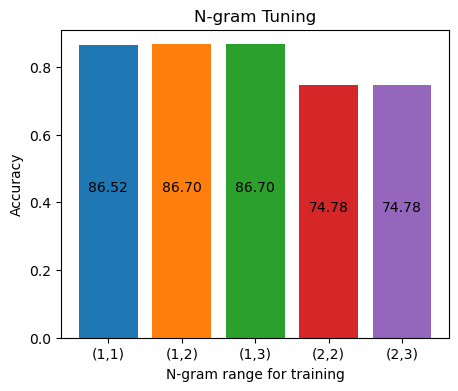

The best n-gram range is (1,2) with an average score of 0.866957


In [17]:
figure = plt.figure(figsize=(5,4))
for i in range(len(params)):
    plt.bar(params[i],scores[i])
    plt.text(params[i],scores[i]/2,"%.2f" % (scores[i] * 100),ha="center")

plt.title("N-gram Tuning")
plt.xlabel("N-gram range for training")
plt.ylabel("Accuracy")
plt.show()
print("The best n-gram range is (%d,%d)" % (bestM,bestN), "with an average score of %f" % bestScore)

In [47]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)

m = bestM
n = bestN
bestScore = 0
bestMinDf = 0
bestMaxDf = 0
scores = []
params = []
mins = np.linspace(10,150,10,dtype=int)
maxs = [0.3, 0.5, 0.7]
max_df = 0.5

for min_df in mins:
    # for max_df in maxs:
    avgTrain = 0
    avgVal = 0
    k = 1
    for train_i, test_i in kfold.split(X_train,y_train):

        #Getting feature matrices
        X_train_features, X_test_features, _ = FeatureExtraction(X_train[train_i],X_train[test_i],m,n,max_df=max_df,min_df=min_df)

        #Classification
        pred_train_labels, pred_test_labels = Classify(X_train_features,X_test_features,y_train[train_i])

        avgTrain += accuracy_score(y_train[train_i],pred_train_labels)
        avgVal += accuracy_score(y_train[test_i],pred_test_labels)

        k += 1

    avgTrain = avgTrain / kfold.get_n_splits()
    avgVal = avgVal / kfold.get_n_splits()
    scores.append(avgVal)
    params.append('(%d,%.2f)' % (min_df,max_df))

    if avgVal > bestScore:
        bestScore = avgVal
        bestMinDf = min_df
        bestMaxDf = max_df

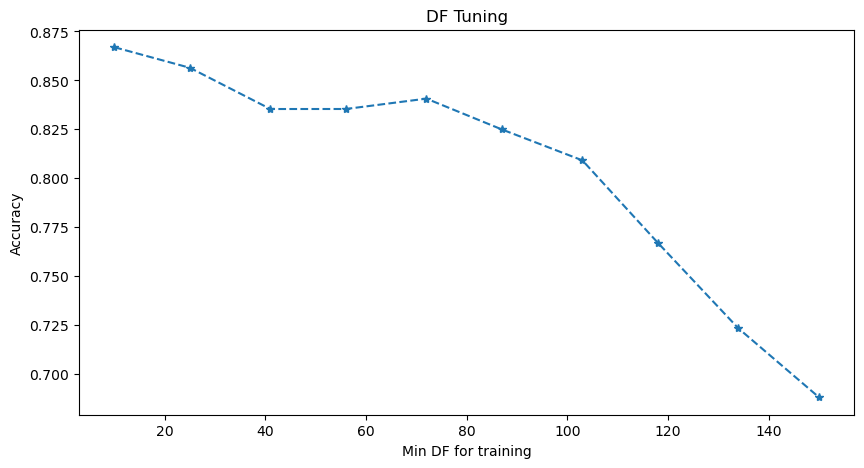

The best min and max df values are 10 and 0.50 respectively, with an average score of 0.866957


In [48]:
figure = plt.figure(figsize=(10,5))

#for i in range(len(params)):
    #plt.plot(mins[i],scores[i],'--*')
    #plt.text(params[i],scores[i]/2,"%.2f" % (scores[i] * 100),ha="center")
plt.plot(mins,scores,'--*')
plt.title("DF Tuning")
plt.xlabel("Min DF for training")
plt.ylabel("Accuracy")
plt.show()

print("The best min and max df values are %d and %.2f respectively," % (bestMinDf,bestMaxDf), "with an average score of %f" % bestScore)

## Training and Testing

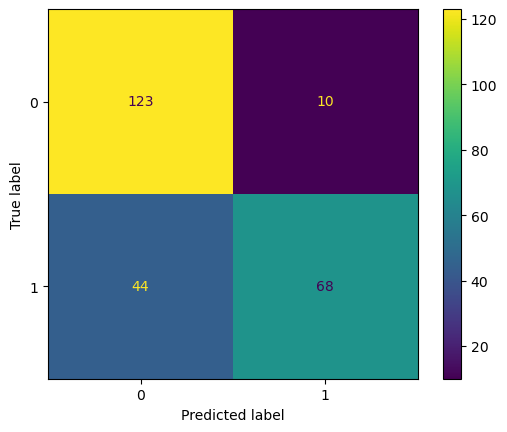

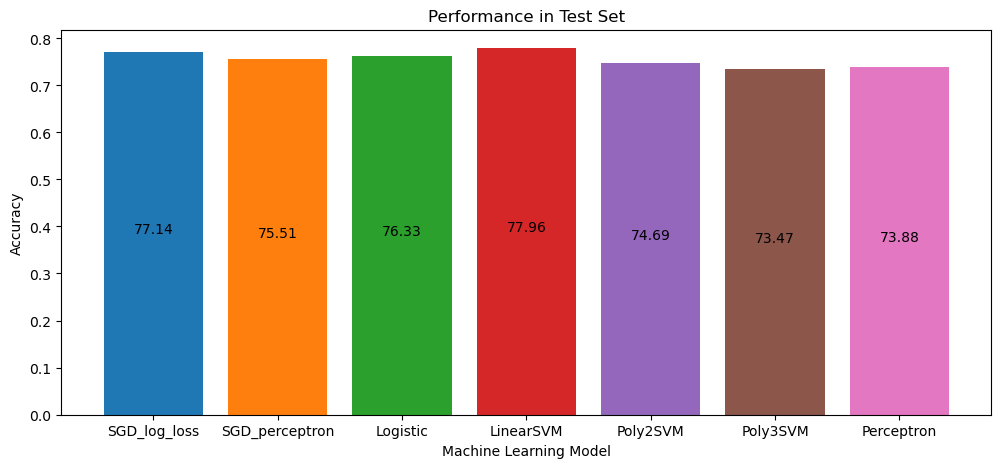

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Getting feature matrices
X_train_features, X_test_features, vocab = FeatureExtraction(X_train,X_test,2,3,max_df=bestMaxDf,min_df=bestMinDf)

#Classification
methods = ['SGD_log_loss','SGD_perceptron','Logistic','LinearSVM','Poly2SVM','Poly3SVM','Perceptron']
scores = []
for method in methods:
    pred_train_labels, pred_test_labels = Classify(X_train_features,X_test_features,y_train,method=method)
    scores.append(accuracy_score(y_test,pred_test_labels))
    if method == 'LinearSVM':
        ConfusionMatrixDisplay.from_predictions(y_test,pred_test_labels)

plt.figure(figsize=(12,5))
for i in range(len(methods)):
    plt.bar(methods[i],scores[i],0.8)
    plt.text(i,scores[i]/2,"%.2f" % (scores[i] * 100),ha="center")

plt.title("Performance in Test Set")
plt.xlabel("Machine Learning Model")
plt.ylabel("Accuracy")
plt.show()